In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline # plot in cell
from sklearn import metrics
import pandas as pd
from scipy import signal
from scipy import stats

import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# for svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

In [2]:
import pandas as pd

data = pd.read_excel(r'F:\Program\OneDrive\TLNC\ISI\data\data.xlsx')
data.columns
data

Index(['Person', 'State', 'x', 'y', 'z'], dtype='object')

,Person,State,x,y,z
0,33.0,Jogging,-0.694638,12.680544,0.503953
1,33.0,Jogging,5.012288,11.264028,0.953424
2,33.0,Jogging,4.903325,10.882658,-0.081722
3,33.0,Jogging,-0.612916,18.496431,3.023717
4,33.0,Jogging,-1.184970,12.108489,7.205164
...,...,...,...,...,...
1048570,7.0,Standing,-8.080000,5.090000,-0.690000
1048571,7.0,Standing,-8.120000,5.520000,-0.800000
1048572,7.0,Standing,-7.890000,5.790000,-0.720000
1048573,7.0,Standing,-7.890000,5.980000,-0.270000


In [3]:
G = 9.81
data['x'] = data['x'].div(G)
data['y'] = data['y'].div(G)
data['z'] = data['z'].div(G)
data

,Person,State,x,y,z
0,33.0,Jogging,-0.070809,1.292614,0.051371
1,33.0,Jogging,0.510937,1.148219,0.097189
2,33.0,Jogging,0.499829,1.109343,-0.008330
3,33.0,Jogging,-0.062479,1.885467,0.308228
4,33.0,Jogging,-0.120792,1.234301,0.734471
...,...,...,...,...,...
1048570,7.0,Standing,-0.823649,0.518858,-0.070336
1048571,7.0,Standing,-0.827727,0.562691,-0.081549
1048572,7.0,Standing,-0.804281,0.590214,-0.073394
1048573,7.0,Standing,-0.804281,0.609582,-0.027523


In [4]:
data = data.drop(columns = 'Person')
df = data.groupby(['State'])
df.first()

,x,y,z
State,,,
Downstairs,-0.004165,0.508160,0.663662
Jogging,-0.070809,1.292614,0.051371
Sitting,0.265036,0.984709,0.105520
Standing,-0.191641,1.004077,-0.023603
Upstairs,1.031592,0.441516,-0.385979
Walking,0.086082,0.816388,0.284625


In [5]:
Downstairs = df.get_group(('Downstairs'))
Jogging = df.get_group(('Jogging'))
Sitting = df.get_group(('Sitting'))
Standing = df.get_group(('Standing'))
Upstairs = df.get_group(('Upstairs'))
Walking = df.get_group(('Walking'))

len(Downstairs)
len(Jogging)
len(Sitting)
len(Standing)
len(Upstairs)
len(Walking)

97813

325975

54876

44541

118589

406776

In [6]:
stand = Standing
len(stand)
sit = Sitting
len(sit)
jog = Jogging
len(jog)
walk = Downstairs.append(Upstairs).append(Walking)
len(walk)

44541

54876

325975

623178

In [7]:
#Check nan value & remove 
len(walk.index)

walk = walk.dropna()
walk.index = pd.RangeIndex(len(walk.index))
len(walk.index)
walk.isnull().sum().sum()

type(walk)

623178

623177

0

pandas.core.frame.DataFrame

In [8]:
# Split dataset to 2 parts: Train (60%) - Test (40%)\n",
# 200 samples/frame
#window_size = 10s
#Fs = 20Hz

frame = 200
stride = 100 #step

# range (start, stop, step)
X_stand_train = [stand[i:i+frame] for i in range(0, int(len(stand)*0.6), stride)] 
X_stand_test = [stand[i:i+frame] for i in range(int(len(stand)*0.6), len(stand), stride)
                                                    if i+frame<=len(stand)]

X_sit_train = [sit[i:i+frame] for i in range(0, int(len(sit)*0.6), stride)]
X_sit_test = [sit[i:i+frame] for i in range(int(len(sit)*0.6), len(sit),stride)
                                           if i+frame<=len(sit)]

X_jog_train = [jog[i:i+frame] for i in range(0, int(len(jog)*0.6), stride)] 
X_jog_test = [jog[i:i+frame] for i in range(int(len(jog)*0.6), len(jog), stride) 
                                            if i+frame<=len(jog)]

X_walk_train = [walk[i:i+frame] for i in range(0, int(len(walk)*0.6), stride)] 
X_walk_test = [walk[i:i+frame] for i in range(int(len(walk)*0.6), len(walk), stride) 
                                            if i+frame<=len(walk)]
print ('X_stand_train: ', len(X_stand_train))
print ('X_stand_test: ', len(X_stand_test))

print ('X_sit_train: ', len(X_sit_train))
print ('X_sit_test: ', len(X_sit_test))

print ('X_jog_train: ', len(X_jog_train))
print ('X_jog_test: ', len(X_jog_test))

print ('X_walk_train: ', len(X_walk_train))
print ('X_walk_test: ', len(X_walk_test))

X_stand_train:  268
X_stand_test:  177
X_sit_train:  330
X_sit_test:  218
X_jog_train:  1956
X_jog_test:  1302
X_walk_train:  3740
X_walk_test:  2491


In [9]:
train_data = []
train_label = []

test_data = []
test_label = []

for acts in X_stand_train:
    train_data.append(acts)
    train_label.append(0)
    
for acts in X_sit_train:
    train_data.append(acts)
    train_label.append(1)
    
for acts in X_jog_train:
    train_data.append(acts)
    train_label.append(2)

for acts in X_walk_train:
    train_data.append(acts)
    train_label.append(3)

print('train-data length: ', len(train_data) )
print('train-label length: ', len(train_label) )
#print(train_label)
      
# For TEST

for acts in X_stand_test:
    test_data.append(acts)
    test_label.append(0)

for acts in X_sit_test:
    test_data.append(acts)
    test_label.append(1)
        
for acts in X_jog_test:
    test_data.append(acts)
    test_label.append(2)

for acts in X_walk_test:
    test_data.append(acts)
    test_label.append(3)

print('test-data length: ', len(test_data))
print('test-label length: ', len(test_label))

train-data length:  6294
train-label length:  6294
test-data length:  4188
test-label length:  4188


In [121]:
from scipy.stats import kurtosis, skew

def averageLength(x,y,z):
    summ = 0
    for i,j,k in zip(x,y,z):
        summ += i*i + j*j + k*k
    summ = np.sqrt(summ)
    return summ

def featuresFromBuffer(at):
    feat = np.zeros(50)   
    
    x = np.array(at.iloc[:,0], dtype=np.float64)   
    y = np.array(at.iloc[:,1], dtype=np.float64)   
    z = np.array(at.iloc[:,2], dtype=np.float64)  
    
    means = [np.mean(i) for i in [x, y, z]]
    feat[0:3] = means 
    
    rms = [np.sqrt(np.mean(i**2)) for i in [x, y, z]]
    feat[3:6] = rms

    # Standard deviation
    std = [np.std(i) for i in [x, y, z]]
    feat[6:9] = std

    # Median
    med = [np.median(i) for i in [x, y, z]]
    feat[9:12] = med
    
    # Range
    Range = [np.amax(i)-np.amin(i) for i in [x, y, z]]    
    feat[12:15] = Range
    
    #max
    maxValue = [np.amax(i) for i in [x,y,z]]
    feat[15:18] = maxValue

    minValue = [np.amin(i) for i in [x,y,z]]
    feat[18:21] = minValue
    
    #skew
    skewValue = [skew(i) for i in [x,y,z]]
    feat[21:24] = skewValue
    
    #kurtosis
    kurtosisValue = [kurtosis(i) for i in [x,y,z]]
    feat[24:27] = kurtosisValue
    
    #slope 
    slope = np.sqrt(pow(np.amax(x)-np.amin(x),2)+pow(np.amax(y)-np.amin(y),2)+pow(np.amax(z)-np.amin(z),2))
    feat[27] = slope
    
    #res
    feat[28] = averageLength(x,y,z)
    
     #abs
    meanAbs = [abs(np.mean(i)) for i in [x,y,z]]
    feat[29:32] = meanAbs
    
    medianAbs = [abs(np.median(i)) for i in [x, y, z]]
    feat[32:35] = medianAbs
    
    stdAbs = [abs(np.std(i)) for i in [x, y, z]]
    feat[35:38] = stdAbs
    
    minAbs = [abs(np.amin(i)) for i in [x,y,z]]
    feat[38:41] = minAbs
    
    maxAbs = [abs(np.amax(i)) for i in [x,y,z]]
    feat[41:44] = maxAbs
    
    skewAbs = [abs(skew(i)) for i in [x,y,z]]
    feat[44:47] = skewAbs
    
    kurtosisAbs = [abs(kurtosis(i)) for i in [x,y,z]]
    feat[47:50] = kurtosisAbs
    
    
#     #tilt angle 
#     #mean 
#     feat[29] = np.arcsin(np.mean(y)/averageLength(x,y,z))
#     #std
#     feat[30] = np.arcsin(np.std(y)/averageLength(x,y,z))
#     #skew
#     feat[31] = np.arcsin(skew(y)/averageLength(x,y,z))
#     #kurtosis
#     feat[32] = np.arcsin(kurtosis(y)/averageLength(x,y,z))
    
    
   
    return feat  

In [108]:
x = [1,3,4,25,6]
y = [10, 12, 15, 3, -3]
z = [4, 2, 4, 0, 7]

def res (x,y,z):
    summ = 0
    for i,j,k in zip(x,y,z): 
        summ += i*i+j*j+k*k
 
    summ = np.sqrt(summ)
    return summ

res(x,y,z)

abs(-3)
    

35.482389998420345

3

In [122]:
# Tạo mảng features 

train_features = []
test_features = []
for action in train_data:
    feat = featuresFromBuffer(action)
    train_features.append(feat)  

for action in test_data:
    feat = featuresFromBuffer(action)
    test_features.append(feat)

len(train_features)
len(test_features)

6294

4188

In [123]:
#lower accuracy (nan value -> 0)
np.where(np.isnan(train_features)) 
train_features = np.nan_to_num(train_features)
np.where(np.isnan(test_features))
test_features = np.nan_to_num(test_features)      

len(train_features)
len(train_label)

(array([], dtype=int64), array([], dtype=int64))

(array([], dtype=int64), array([], dtype=int64))

6294

6294

In [124]:
#Classifier 

from sklearn.feature_selection import SelectFromModel
print("Gradient Boosting Decision Tree:")
from sklearn.ensemble import GradientBoostingClassifier
clf1 = GradientBoostingClassifier(learning_rate=0.05,max_depth=3,n_estimators=100).fit(train_features, train_label)
#format: pass score in {:.3f}
print('Accuracy of GBDT classifier on training set: {:.3f}'
     .format(clf1.score(train_features, train_label)))
print('Accuracy of GBDT classifier on test set: {:.3f}'
     .format(clf1.score(test_features, test_label)))

print("\n\nDecision Tree:") 
from sklearn.tree import DecisionTreeClassifier
from adspy_shared_utilities import plot_decision_tree 

clf2 = DecisionTreeClassifier(max_depth=4).fit(train_features, train_label)

print('Accuracy of Decision Tree classifier on training set: {:.3f}'.format(clf2.score(train_features, train_label)))
print('Accuracy of Decision Tree classifier on test set: {:.3f}'
.format(clf2.score(test_features, test_label)))


print("\n\nSVM:")
clf3 = SVC(C=100, gamma='scale').fit(train_features, train_label)
print("Accuracy on training set: {:.2f}".format(clf3.score(train_features, train_label)))
print("Accuracy on test set: {:.2f}".format(clf3.score(test_features, test_label)))


print('\n\n Random Forests: ')
from sklearn.ensemble import RandomForestClassifier
clf4 = RandomForestClassifier(n_estimators=200, random_state=0).fit(train_features, train_label)

print('Accuracy of RF classifier on training set: {:.3f}'
     .format(clf4.score(train_features, train_label)))
print('Accuracy of RF classifier on test set: {:.3f}'
     .format(clf4.score(test_features, test_label)))


print('\n\n KNeighbor: ')
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance').fit(train_features, train_label)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(train_features, train_label)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(test_features, test_label)))


Gradient Boosting Decision Tree:
Accuracy of GBDT classifier on training set: 0.996
Accuracy of GBDT classifier on test set: 0.878


Decision Tree:
Accuracy of Decision Tree classifier on training set: 0.981
Accuracy of Decision Tree classifier on test set: 0.811


SVM:
Accuracy on training set: 0.99
Accuracy on test set: 0.92


 Random Forests: 
Accuracy of RF classifier on training set: 1.000
Accuracy of RF classifier on test set: 0.874


 KNeighbor: 
Accuracy of K-NN classifier on training set: 1.00
Accuracy of K-NN classifier on test set: 0.94


<Figure size 800x720 with 0 Axes>

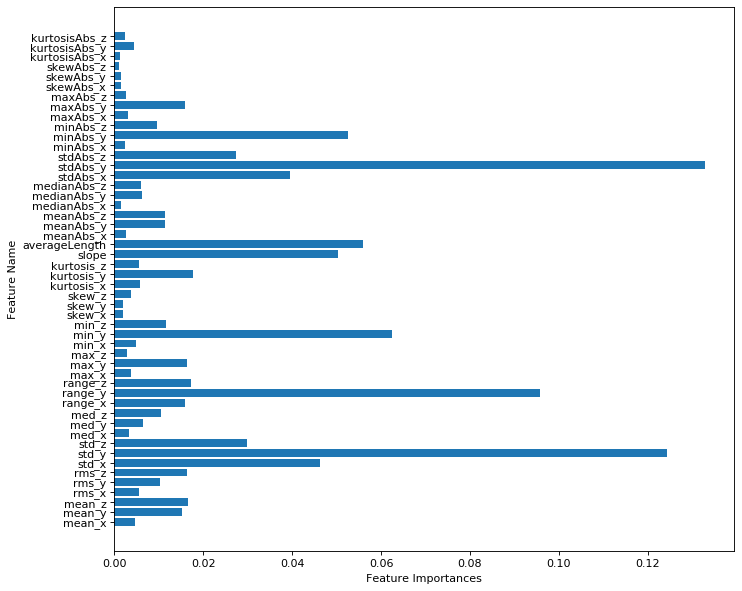

Feature importances: [0.00470027 0.01518969 0.01659709 0.00549461 0.01035489 0.01640806
 0.04614836 0.12421782 0.02979896 0.00329065 0.00645473 0.01059136
 0.01582807 0.09574515 0.01730468 0.00364777 0.01638737 0.00291682
 0.00483627 0.06252193 0.01170257 0.00186311 0.00185219 0.00372424
 0.00585373 0.01763241 0.0055181  0.05035896 0.05589122 0.00255608
 0.0114337  0.01134637 0.00158462 0.00616581 0.00606846 0.03941368
 0.13282107 0.02730094 0.00235103 0.05266824 0.00966103 0.0030661
 0.0158883  0.00267278 0.00140257 0.00160464 0.00106369 0.00135727
 0.00432479 0.00241773]


In [130]:
# adspy_shared_utilities import plot_feature_importances
# Atturibute Feature importances only use for classifiers contain trees

feature_names = ['mean_x', 'mean_y', 'mean_z', 
                'rms_x', 'rms_y', 'rms_z',
                'std_x', 'std_y', 'std_z',
                'med_x', 'med_y', 'med_z',
                'range_x', 'range_y', 'range_z',
                'max_x','max_y','max_z',
                'min_x','min_y', 'min_z',
                'skew_x','skew_y','skew_z',
                'kurtosis_x','kurtosis_y','kurtosis_z',
                'slope', 'averageLength',
                'meanAbs_x','meanAbs_y','meanAbs_z',
                'medianAbs_x','medianAbs_y','medianAbs_z',
                'stdAbs_x', 'stdAbs_y','stdAbs_z',
                'minAbs_x','minAbs_y','minAbs_z',
                'maxAbs_x','maxAbs_y','maxAbs_z',
                'skewAbs_x','skewAbs_y','skewAbs_z',
                'kurtosisAbs_x','kurtosisAbs_y','kurtosisAbs_z']
#                'meanTA','stdTA','skewTA','kurtosisTA']


def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature Importances")
    plt.ylabel("Feature Name")
    plt.yticks(np.arange(c_features), feature_names)
    
plt.figure(figsize=(10,9), dpi=80)
plot_feature_importances(clf4, feature_names)
plt.show()

print('Feature importances: {}'.format(clf4.feature_importances_))